In [185]:
import os
import codecs
import datetime as dt
import nltk
from xgboost import XGBClassifier, plot_importance
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora, models
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    warnings.filterwarnings("ignore",category=FutureWarning)
    import pyLDAvis.gensim
    import pandas as pd
    import numpy as np

In [186]:
# Read in data
df_data = pd.read_pickle(r'C:\DiskD\MFin_NLP' + os.sep + 'tokenized_data.pkl')
df_data = df_data.set_index('dates')  # set dates to be the index for easier checking the data alignment
df_data.head(3)

,statement,minute,target_rate,target_rate_lead1,target_rate_lead3,target_rate_lead6,diff_1,diff_3,diff_6,tokenized_statement,tokenized_minute
dates,,,,,,,,,,,
1993-02-03,NaN,A meeting of the Federal Open Market Committee...,3.0,3.0,3.0,3.00,0.0,0.0,0.00,NaN,a meeting of the federal open market committee...
1993-03-23,NaN,A meeting of the Federal Open Market Committee...,3.0,3.0,3.0,3.00,0.0,0.0,0.00,NaN,a meeting of the federal open market committee...
1993-05-18,NaN,A meeting of the Federal Open Market Committee...,3.0,3.0,3.0,3.25,0.0,0.0,0.25,NaN,a meeting of the federal open market committee...


In [187]:
# We only want minutes data and the corresponding target interest rate, get rid of the rest, drop NA values
df_minute = df_data[['tokenized_minute', 'diff_1']].dropna()
tokenized_minutes = df_minute['tokenized_minute']
# df_statement = df_data[['tokenized_statement', 'diff_1']].dropna()
# tokenized_statements = df_statement['tokenized_statement']

# Instantiate a TFIDF vectorizer
vect = TfidfVectorizer(stop_words='english',
                       max_features=3000,      # 3000 terms(phrases).  
                       ngram_range=(2, 4),     # of length 2-4 words. open market secretariat assistant, market secretariat assistant, secretariat assistant
                       token_pattern='[a-zA-Z]+')
df_minute.tail(5)

,tokenized_minute,diff_1
dates,,
2019-07-31,minutes of the federal open market committee\n...,-0.25
2019-09-18,minutes of the federal open market committee\n...,-0.25
2019-10-30,minutes of the federal open market committee\n...,-0.25
2019-12-11,minutes of the federal open market committee\n...,0.00
2020-01-29,minutes of the federal open market committee\n...,-0.50


In [188]:
# Latent Dirichlet Allocation(First try)
df_tfidf = vect.fit_transform(df_minute['tokenized_minute'])
text= pd.DataFrame(df_tfidf.toarray(), columns=vect.get_feature_names())
text

,acceptable intermeeting,acceptable intermeeting period,acceptable intermeeting period reserve,accommodative financial,accommodative financial conditions,accommodative monetary,accommodative monetary policy,accommodative stance,accommodative stance monetary,accommodative stance monetary policy,...,year treasury,year year,yield curve,yields declined,yields investment,yields nominal,york instructed,york instructed execute,york instructed execute transactions,york respectively
0,0.035299,0.035299,0.023761,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.034640,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.067961,0.067961,0.045746,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.068248,0.068248,0.045939,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.022325,0.020300,0.0,0.000000,0.000000,0.000000,0.000000,0.019516
3,0.053519,0.053519,0.036025,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.017507,0.015919,0.0,0.000000,0.000000,0.000000,0.000000,0.015304
4,0.070192,0.070192,0.047248,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.022343,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.000000,0.000000,0.000000,0.009001,0.009435,0.017218,0.017866,0.000000,0.0,0.0,...,0.000000,0.008736,0.020751,0.009435,0.0,0.009359,0.004941,0.004941,0.004941,0.009070
196,0.000000,0.000000,0.000000,0.009485,0.009942,0.009072,0.000000,0.019414,0.0,0.0,...,0.010639,0.009205,0.021866,0.009942,0.0,0.000000,0.005207,0.005207,0.005207,0.009558
197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.037849,0.000000,0.0,0.008535,0.009013,0.009013,0.009013,0.016543
198,0.000000,0.000000,0.000000,0.010610,0.011121,0.000000,0.000000,0.000000,0.0,0.0,...,0.011901,0.000000,0.012230,0.000000,0.0,0.011032,0.005825,0.005825,0.005825,0.010691


In [189]:
token_text = [text.columns[text.loc[index, :].to_numpy().nonzero()] for index in text.index]
dictionary = corpora.Dictionary(token_text)
corpus = [dictionary.doc2bow(text) for text in token_text]
lda= models.ldamodel.LdaModel(corpus,
                                      id2word=dictionary,      # Matches each word to its "number" or "spot" in the dictionary
                                      num_topics=4,             # Number of topics to find
                                      passes=10,                  # Number of iterations to go through
                                      minimum_probability=0.01)  # Only include topics above this probability threshold

lda.print_topics() # examine the topics to see whether they make sense

[(0,
  '0.001*"received federal" + 0.001*"m information" + 0.001*"received federal open market" + 0.001*"target range" + 0.001*"directs desk" + 0.001*"information received federal open" + 0.001*"range federal funds rate" + 0.001*"information received federal" + 0.001*"m information received" + 0.001*"target range federal"'),
 (1,
  '0.001*"market secretariat assistant" + 0.001*"open market secretariat assistant" + 0.001*"secretariat assistant" + 0.001*"directive called" + 0.001*"assistant secretary mr" + 0.001*"secretary mr" + 0.001*"members commented" + 0.001*"markets open market transactions" + 0.001*"open market transactions" + 0.001*"policy intermeeting period ahead"'),
 (2,
  '0.001*"wilcox associate economists" + 0.001*"wilcox associate" + 0.001*"open market operations foreign" + 0.001*"equipment software" + 0.001*"market operations foreign" + 0.001*"market operations foreign currencies" + 0.001*"instructed execute transactions account" + 0.001*"statement released" + 0.001*"wilco

In [190]:
# draw the graph for visualization
graph = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(graph)

C:\DiskD\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## LDA Model
1. Extract Noun Phrases
2. Create Document-Term Matrix using noun phrases as terms
3. Run LDA Model

In [191]:
# Try using noun phrases tokens to form our corpus
'''try to parse out only nouns phrases from the Fed minutes as tokens'''
'''tokenize minutes into noun phrases'''
from textblob import TextBlob

df_data = pd.read_pickle(r'C:\DiskD\MFin_NLP' + os.sep + 'tokenized_data.pkl')
df_data = df_data.set_index('dates')  # set dates to be the index for easier checking the data alignment
df_minute = df_data[['minute', 'diff_1', 'tokenized_minute']].dropna()
df_minute['minute'] = df_minute['minute'].apply(lambda x: x.lower())

print('Tokenizing noun phrase......................................')
df_minute['tokenized_noun_phrase'] = df_minute['tokenized_minute'].apply(lambda x: TextBlob(x).noun_phrases)
df_minute.head(10)
# df_minute.to_pickle(os.getcwd() + os.sep + 'tokenized_noun_phrase.pkl')

Tokenizing noun phrase......................................


,minute,diff_1,tokenized_minute,tokenized_noun_phrase
dates,,,,
1993-02-03,a meeting of the federal open market committee...,0.00,a meeting of the federal open market committee...,"[federal open market committee, federal reserv..."
1993-03-23,a meeting of the federal open market committee...,0.00,a meeting of the federal open market committee...,"[federal open market committee, federal reserv..."
1993-05-18,a meeting of the federal open market committee...,0.00,a meeting of the federal open market committee...,"[federal open market committee, federal reserv..."
1993-07-07,a meeting of the federal open market committee...,0.00,a meeting of the federal open market committee...,"[federal open market committee, federal reserv..."
1993-08-17,a meeting of the federal open market committee...,0.00,a meeting of the federal open market committee...,"[federal open market committee, federal reserv..."
1993-09-21,a meeting of the federal open market committee...,0.00,a meeting of the federal open market committee...,"[federal open market committee, federal reserv..."
1993-11-16,a meeting of the federal open market committee...,0.00,a meeting of the federal open market committee...,"[federal open market committee, federal reserv..."
1993-12-21,a meeting of the federal open market committee...,0.25,a meeting of the federal open market committee...,"[federal open market committee, federal reserv..."
1994-02-04,a meeting of the federal open market committee...,0.25,a meeting of the federal open market committee...,"[federal open market committee, federal reserv..."


### The term are noun phrases only

In [192]:
df_minute['tokenized_noun_phrase'][0]


WordList(['federal open market committee', 'federal reserve system', 'mr. greenspan', 'chairman mr. corrigan', 'vice chairman mr. angell mr. boehne mr. keehn mr. kelley mr. laware mr. lindsey mr. mcteer mr. mullins ms. phillips mr. stern messrs. broaddus', 'alternate members', 'federal open market committee messrs. hoenig', 'federal reserve banks', 'kansas city', 'st. louis', 'mr. kohn', 'economist mr. bernard', 'deputy secretary mr. coyne', 'assistant secretary mr. gillum', 'assistant secretary mr.', 'general counsel mr. patrikis,1', 'deputy general counsel mr. prell', 'economist mr. truman', 'economist messrs. r. davis', 'associate economists mr. mcdonough', 'open market account ms. greene', 'deputy manager', 'foreign operations ms. lovett,2', 'deputy manager', 'domestic operations mr. ettin', 'deputy director', 'governors mr. stockton', 'associate director', 'governors mr. madigan', 'assistant director', 'monetary affairs', 'governors mr. brady,3 section chief', 'monetary affairs', 

In [193]:
'''helper function. dummy tokenizer. Doesn't do anything'''
def dummy_fun(doc):
    return doc
vect = TfidfVectorizer(              # This way we can fit a collections of documents already tokenized
    max_features=3000,
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
)
# df_minute = pd.read_pickle(os.getcwd() + os.sep + 'tokenized_noun_phrase.pkl')
df_tfidf = vect.fit_transform(df_minute['tokenized_noun_phrase'])
text= pd.DataFrame(df_tfidf.toarray(), columns=vect.get_feature_names())
text

,'s action,'s meeting,1-1/4 percent,1-3/4 percent,1. system operations,10-year treasury note,10-year treasury yield,12-month basis,12-month percentage,12-month period,...,william wascher,worker benefits,worker compensation,year 's,year 's pace,year-ahead inflation,year-end pressures,year-over-year basis,yield curve,¼ percentage point
0,0.0,0.0,0.0,0.000000,0.030625,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.065985,0.0,0.080626,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.037319,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.044235,0.028081,0.000000,...,0.015007,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
196,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.063319,0.026797,0.000000,...,0.014321,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.042742,0.0
197,0.0,0.0,0.0,0.061990,0.000000,0.0,0.0,0.016426,0.020854,0.018345,...,0.011145,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.033263,0.0
198,0.0,0.0,0.0,0.097247,0.000000,0.0,0.0,0.025767,0.000000,0.028778,...,0.017484,0.0,0.0,0.035180,0.0,0.0,0.032029,0.0,0.000000,0.0


In [194]:
token_text = [text.columns[text.loc[index, :].to_numpy().nonzero()] for index in text.index]
dictionary = corpora.Dictionary(token_text)
corpus = [dictionary.doc2bow(text) for text in token_text]

### Trial and Error: Tune the function parameters
1. num_topics: Number of topics to find
2. passes: Number of interations each token goes through


In [195]:
lda= models.ldamodel.LdaModel(corpus,
                                      id2word=dictionary,# Matches each word to its "number" or "spot" in the dictionary
                                      num_topics=6,  # Number of topics to find
                                      passes=6,      # Number of interations each token goes through
                                      random_state=6, 
                                      minimum_probability=0.01)  # Only include topics above this probability threshold
for topic in lda.print_topics():
    print(topic)

(0, '0.002*"jerome h. powell" + 0.002*"securities transactions" + 0.002*"percent objective" + 0.002*"federal reserve \'s agency" + 0.002*"labor market" + 0.002*"dollar roll" + 0.002*"esther l. george" + 0.002*"intervention operations" + 0.002*"committee \'s longer-run objective" + 0.002*"economic reasons"')
(1, '0.003*"foreign exchange markets" + 0.003*"domestic policy directive" + 0.003*"unanimous vote" + 0.003*"federal reserve banks" + 0.003*"senior vice presidents" + 0.003*"system account" + 0.003*"federal open market committee" + 0.003*"monetary affairs" + 0.003*"new york" + 0.003*"alternate members"')
(2, '0.002*"primary credit rate" + 0.002*"general counsel michael" + 0.002*"price index" + 0.002*"excess reserve balances" + 0.002*"african americans" + 0.002*"personal consumption expenditures" + 0.002*"secretary matthew m. luecke" + 0.002*"federal open market committee" + 0.002*"federal reserve system" + 0.002*"financial conditions"')
(3, '0.003*"fomc meeting" + 0.003*"economic sit

In [196]:
graph = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(graph)

C:\DiskD\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Topic Analysis
After a careful analysis of the most important terms with highest probability of belonging to each topic, 
we decided that the topics might corresponded to the following themes:
1. Economic Conditions and Activities
2. Market Operations
3. Financial Market
4. Inflation(Price Level)
5. Labor Market
6. Policy

In [197]:
# interpret the final results
# We can re-rank the words and introduce new terms that are more specific to a topic of interest. We do that by
#                decreasing the value of lambda to put more weight on the ratio of red to grey, or the ratio of the frequency given
#                the topic to the overall frequency of the word.
# topic_dict = {1:'Financial Market', 2:'Inflation(Price Index)', 3:'Voting Decisions', \
#              4:'Economic Conditions and Activities', 5:'Foreign Policies', 6:'Long-term outlook/forecast'}
topic_dict = {1:'Economic Conditions and Activities', 2:'Policy and Market Operations', 3:'Financial Market', \
             4:'Inflation(Price Level)', 5:'Labor Market', 6:'Foreign Relationship'}

### Now we have the topics. 
### Let’s go back to see which topic each minutes emphasized on.  

In [198]:
# Look at which topic each minutes contains
corpus_transformed = lda[corpus]
related_topics_list = []
for related_topics in corpus_transformed:
    topic_list = []
    for topic in related_topics:
        a = topic[0]
        topic_list.append(topic_dict.get(a+1))
    related_topics_list.append(topic_list)
        
list(zip(related_topics_list, df_data.index[text.index].strftime('%Y%m%d')))

[(['Policy and Market Operations', 'Labor Market'], '19930203'),
 (['Policy and Market Operations'], '19930323'),
 (['Policy and Market Operations'], '19930518'),
 (['Policy and Market Operations'], '19930707'),
 (['Policy and Market Operations'], '19930817'),
 (['Policy and Market Operations'], '19930921'),
 (['Policy and Market Operations'], '19931116'),
 (['Policy and Market Operations'], '19931221'),
 (['Policy and Market Operations', 'Labor Market'], '19940204'),
 (['Policy and Market Operations'], '19940322'),
 (['Policy and Market Operations'], '19940418'),
 (['Policy and Market Operations'], '19940517'),
 (['Policy and Market Operations'], '19940706'),
 (['Policy and Market Operations'], '19940816'),
 (['Policy and Market Operations'], '19940927'),
 (['Policy and Market Operations'], '19941115'),
 (['Policy and Market Operations'], '19941220'),
 (['Policy and Market Operations', 'Labor Market'], '19950201'),
 (['Policy and Market Operations'], '19950328'),
 (['Policy and Market

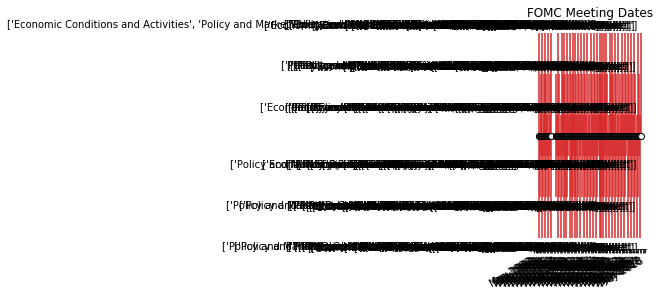

In [199]:
dates = df_data.index[text.index]
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
ax.set(title="FOMC Meeting Dates")
markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)

plt.setp(markerline, mec="k", mfc="w", zorder=3)
# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(dates)))

# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, related_topics_list, vert):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")

# format xaxis with 4 month intervals
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)